### Brainstorm

- Naive tagging is incorrect (Try other ways) that involves collocations/phrases
- Feature Selection methods (try correlation-based, mRmR)
- Topic Modelling

In [800]:
import sys
import argparse
import os
import json
import re
import spacy
import html
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [801]:
indir = os.path.join(os.getcwd(), 'data')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

In [802]:
from a1_preproc import preproc1
from a1_extractFeatures import extract1, extract2
from a1_classify import *
from sklearn.metrics import confusion_matrix

In [803]:
PUNCTS = {'#', '$', '.', ',', ':', '(', ')', '"',"''", "``", "`", "'"}

In [559]:
# allOutput = []
# for subdir, dirs, files in os.walk(indir):
#     for file in files:

#         fullFile = os.path.join(subdir, file)
#         print("Processing " + fullFile)

#         data = json.load(open(fullFile))

#         # Start sampling from the index value dependent on Student ID
#         sample_idx = 999999999 % len(data)
#         for line in data[sample_idx: sample_idx + 10000]:
#             j = json.loads(line)
#             # Extract comment_id, Preprocessed body text, and add a category
#             comment = dict()
#             comment["id"] = j["id"]
#             temp_body = preproc1(j["body"], steps=range(1, 5))
#             comment["cat"] = file
#             comment["body"] = preproc1(temp_body, steps=range(5, 6))
#             comment["untagged_body"] = keyword_extract(temp_body)
#             allOutput.append(comment)

Processing F:\OneDrive - University of Toronto\University\CSC401\A1\data\Alt
Processing F:\OneDrive - University of Toronto\University\CSC401\A1\data\Center
Processing F:\OneDrive - University of Toronto\University\CSC401\A1\data\Left
Processing F:\OneDrive - University of Toronto\University\CSC401\A1\data\Right


In [861]:
allOutput = json.load(open("preproc.json"))

In [808]:
actual_data = [x['cat'] for x in data]

In [809]:
Counter(actual_data)

Counter({'Alt': 10000, 'Center': 10000, 'Left': 10000, 'Right': 10000})

In [558]:
def keyword_extract(comment):
    keywords = set()
    extra_tag = {'NN', 'NNS','NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS'}
    doc = nlp(comment.lower())
    for sentence in doc.sents:
        for token in sentence:
            if token.tag_ in extra_tag:
                if token.tag_ not in string.punctuation \
                   and token.lemma_ not in nlp.Defaults.stop_words \
                   and len(token.lemma_) >= 5:
                    keywords.add(token.lemma_)
    return ' '.join(keywords)

### Finalized Code

In [ ]:
### Split into train and test

In [551]:
cat_dict = {"Left": 0, "Center": 1, "Right": 2, "Alt": 3}

In [862]:
X_full = [comment["untagged_body"] for comment in allOutput]
y_full = np.array([cat_dict[comment["cat"]] for comment in allOutput])
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)

In [863]:
# Sample peek
X_train[0:5]

['adjust codeine holistic approach increase relieve people reach number homeopathy prove program relief prescription doctor difference antiemetic analgesic medicate fraud oxycontin regiment preach intention cannabis',
 'rational disgust israel puppet brutality people misinterpretation bullshit government disagree repeat speach boycott concerned speech',
 'difficult fault rough medication right thing deserve scare',
 'delete',
 '']

In [864]:
train_corpus = []
for tweet in X_train:
    train_corpus.extend(tweet.split(" "))

train_top_labels = [word[0] for word in Counter(train_corpus).most_common(30)]
train_top_occurence = [word[1]/len(train_corpus) for word in Counter(train_corpus).most_common(30)]

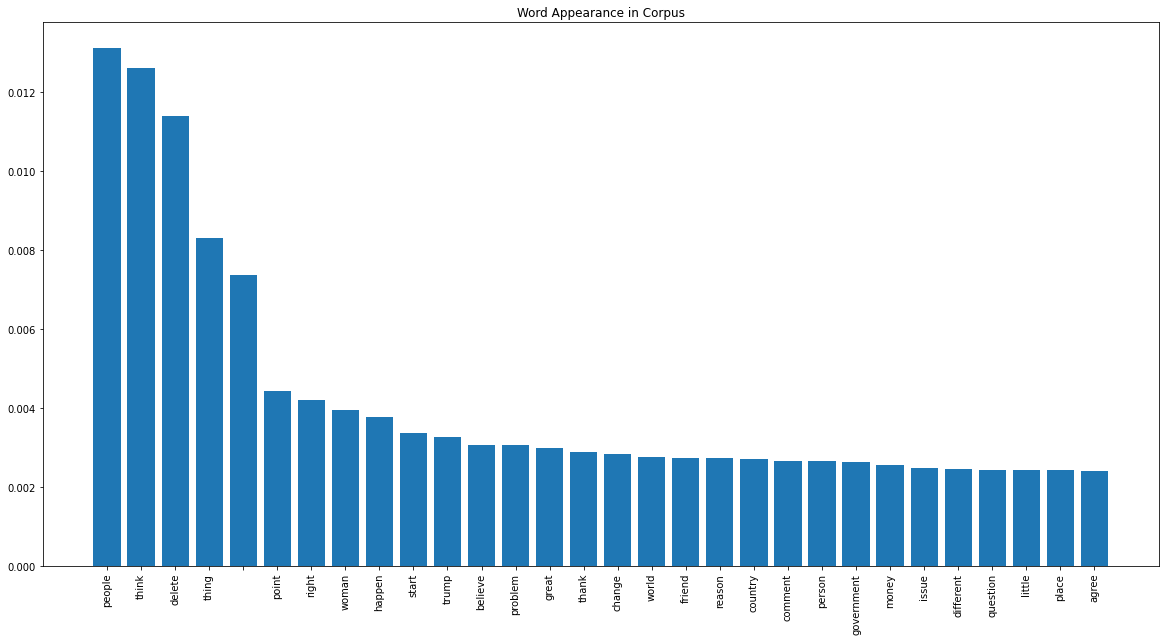

In [865]:
plt.figure(figsize=(20,10));
plt.bar(train_top_labels, train_top_occurence);
plt.title("Word Appearance in Corpus");
plt.xticks(rotation=90);

In [866]:
# Fit on X_Train using a Tfidf Vectorizer (Zipf's law)
tfidf_model = TfidfVectorizer(max_features=100, stop_words='english').fit(X_train)
feature_words = tfidf_model.get_feature_names()
X_train_vec = tfidf_model.transform(X_train)
X_test_vec = tfidf_model.transform(X_test)

In [867]:
num_topics = 20
nmf_output = NMF(n_components=num_topics, init='nndsvd', random_state=401, alpha=0.1, l1_ratio=0.0, max_iter=1000).fit(X_train_vec)
nmf_weights = nmf.components_

In [868]:
def reconstruct_topics(feature_words, nmf_weight, top_words=10):
    topic_dict = {topic:[] for topic in range(len(nmf_weight))}
    for topic in topic_dict:
        topic_dict[topic] = sorted(list(zip(feature_words, nmf_weight[topic])), key=lambda x: -x[1])[:top_words]
    return topic_dict

In [869]:
topic_dict = reconstruct_topics(feature_words, nmf_output.components_)

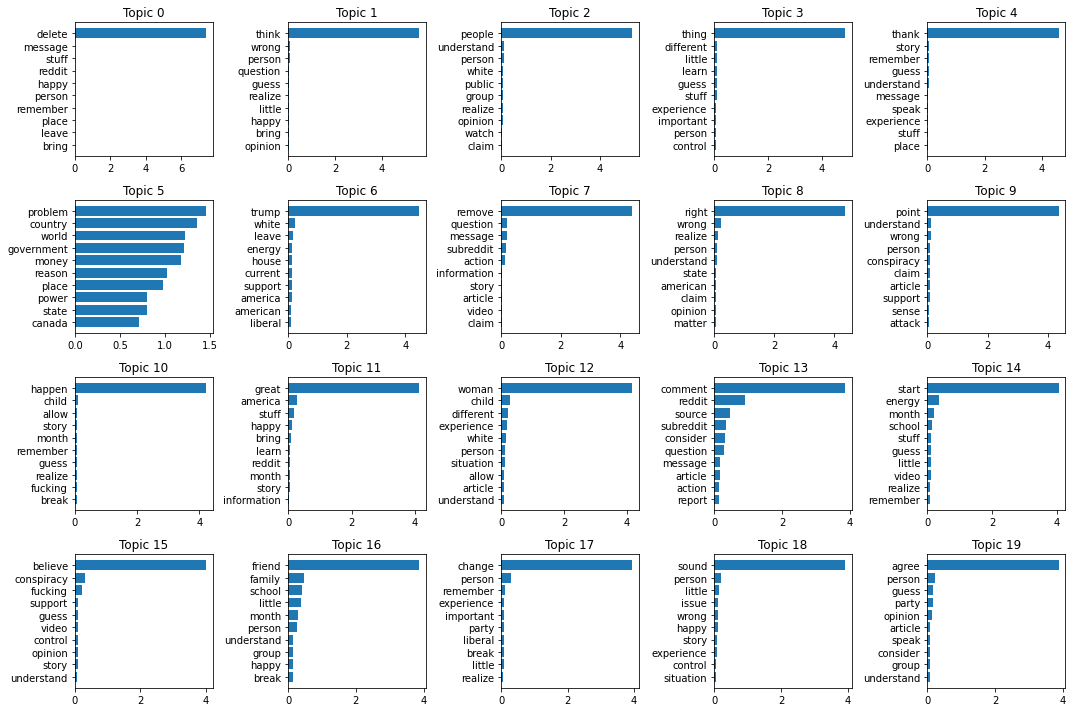

In [871]:
fig, ax = plt.subplots(figsize=(15,10), ncols=5, nrows=4)
for topic in topic_dict:
    word = [w[0] for w in topic_dict[topic]]
    weight = [w[1] for w in topic_dict[topic]]
    ax[topic//5][topic%5].barh(word[::-1], weight[::-1]);
    ax[topic//5][topic%5].set_title(f"Topic {topic}");
plt.tight_layout();
fig.savefig("topic_keywords.png");

In [933]:
class31("bonus", c, d, y_train, y_test)

TODO Section 3.1


4

In [916]:
l = nmf_output.transform(X_train_vec.toarray())
z = nmf_output.transform(X_test_vec.toarray())
c = l/l.sum(axis=1, keepdims=True)
c[np.isnan(c)] = 0
d = z/z.sum(axis=1, keepdims=True)
d[np.isnan(d)] = 0

<ipython-input-932-7c1578df13bc>:1: RuntimeWarning: invalid value encountered in true_divide
  c = l/l.sum(axis=1, keepdims=True)
<ipython-input-932-7c1578df13bc>:3: RuntimeWarning: invalid value encountered in true_divide
  d = z/z.sum(axis=1, keepdims=True)


In [925]:
np.sum(np.isnan(c))

196420

In [929]:
np.sum(np.isnan(c))

0

In [897]:
arr = nmf_output.transform(X_train_vec.toarray().round()).argmax(axis=1)

In [907]:
k = nmf_output.transform(X_train_vec.toarray())[0]

In [911]:
k.max()

0.09462575666811122

In [912]:
(k/k.sum()).max()

0.862501759435995

In [829]:
from scipy.special import softmax

In [914]:
softmax(k).max()

0.05464980042893319

In [915]:
softmax??

In [874]:
topic_df = pd.DataFrame(columns=["topic_label", "political_label"])
topic_df["topic_label"] =nmf_output.transform(X_train_vec).argmax(axis=1)
topic_df["political_label"] = y_train

In [875]:
topic_groupby_label = topic_df.groupby(["topic_label"]).mean().reset_index()

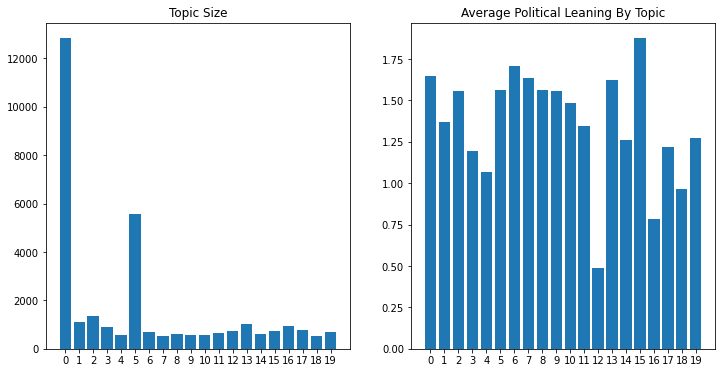

In [876]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6));

topic_groupby_count = topic_df.groupby(["topic_label"]).count().reset_index()
topic_groupby_mean = topic_df.groupby(["topic_label"]).mean().reset_index()
plt.setp(ax, xticks=range(0, 20))
ax[0].bar(topic_groupby_count["topic_label"], topic_groupby_count["political_label"]);
ax[0].set_title("Topic Size");
ax[1].bar(topic_groupby_label["topic_label"], topic_groupby_label["political_label"]);
ax[1].set_title("Average Political Leaning By Topic");
fig.savefig("bonus/topic_breakdown.png");

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [617]:
# https://shravan-kuchkula.github.io/topic-modeling/#vectorize-the-reviews
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.non_negative_factorization.html

In [531]:
result_df = pd.DataFrame(columns=["label", "topic"])
result_df["topic"] = lda.transform(tf).argmax(axis=1)
result_df["label"] = y_label

In [493]:
lda.components_

array([[1.00004799e-01, 1.00007656e-01, 1.00007539e-01, 1.00008275e-01,
        1.00008458e-01, 1.00006930e-01, 1.00003302e-01, 3.25042684e+02,
        1.00010118e-01, 1.00019382e-01, 1.00006723e-01, 1.00008421e-01,
        1.00006763e-01, 1.00009327e-01, 1.00007352e-01, 1.00009826e-01,
        1.00006918e-01, 1.00005645e-01, 4.96682428e+02, 1.00002819e-01,
        2.54795334e+02, 6.27559338e+02, 1.00008201e-01, 1.00004880e-01,
        3.10897093e+02, 1.00010218e-01, 1.00000128e-01, 1.00006271e-01,
        1.00015022e-01, 1.00009934e-01, 2.47970886e+02, 1.00006637e-01,
        1.00005736e-01, 1.00008773e-01, 1.00008003e-01, 1.00007047e-01,
        1.00008369e-01, 1.00006504e-01, 1.00008812e-01, 1.00006575e-01,
        1.00011999e-01, 1.00010106e-01, 1.00012512e-01, 1.00009401e-01,
        1.00005316e-01, 1.00007112e-01, 1.00006683e-01, 1.00010613e-01,
        1.00004603e-01, 1.00005286e-01, 1.00004595e-01, 1.00010360e-01,
        1.00004966e-01, 1.00018314e-01, 1.00006429e-01, 1.000114

In [316]:
### Words that are way too common, human control 

In [491]:
result_df.groupby(["topic"]).mean()

,label
topic,
0,1.603610
1,1.290848
2,1.564481
3,1.302663
4,1.311773
5,1.405355
6,1.474098
7,1.363031
8,1.815092


In [688]:
import csv
BRISTOL_GILHOOLYLOGIE = dict()
WARRINGER = dict()
bgl_path = r"F:\OneDrive - University of Toronto\University\CSC401\A1\Wordlists\BristolNorms+GilhoolyLogie.csv"
war_path = r"F:\OneDrive - University of Toronto\University\CSC401\A1\Wordlists\Ratings_Warriner_et_al.csv"
with open(bgl_path) as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        AOA = int(row["AoA (100-700)"]) if row["AoA (100-700)"].isdigit() else 0
        IMG = int(row["IMG"]) if row["IMG"].isdigit() else 0
        FAM = int(row["FAM"]) if row["FAM"].isdigit() else 0
        BRISTOL_GILHOOLYLOGIE[row['WORD']] = [AOA, IMG, FAM]

with open(war_path) as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        V_Mean_Sum = float(row["V.Mean.Sum"]) if row["V.Mean.Sum"].isdigit() else 0
        A_Mean_Sum = float(row["A.Mean.Sum"]) if row["A.Mean.Sum"].isdigit() else 0
        D_Mean_Sum = float(row["D.Mean.Sum"]) if row["D.Mean.Sum"].isdigit() else 0
        WARRINGER[row['Word']] = [V_Mean_Sum, A_Mean_Sum, D_Mean_Sum]

In [689]:
WARRINGER 

{'aardvark': [0, 0, 0],
 'abalone': [0, 0, 0],
 'abandon': [0, 0, 0],
 'abandonment': [0, 0, 0],
 'abbey': [0, 0, 5.0],
 'abdomen': [0, 0, 0],
 'abdominal': [0, 0, 0],
 'abduct': [0, 0, 0],
 'abduction': [0, 0, 0],
 'abide': [0, 0, 0],
 'abiding': [0, 0, 0],
 'ability': [7.0, 0, 0],
 'abject': [4.0, 0, 0],
 'ablaze': [0, 0, 0],
 'able': [0, 0, 0],
 'abnormal': [0, 0, 0],
 'abnormality': [0, 5.0, 0],
 'abode': [0, 0, 0],
 'abolish': [0, 0, 0],
 'abominable': [0, 0, 0],
 'abomination': [0, 0, 0],
 'abort': [0, 0, 0],
 'abortion': [0, 0, 0],
 'abracadabra': [0, 0, 0],
 'abrasive': [0, 0, 0],
 'abreast': [0, 0, 0],
 'abrupt': [0, 0, 0],
 'abscess': [0, 4.0, 0],
 'absence': [0, 0, 0],
 'absent': [0, 0, 0],
 'absinthe': [0, 0, 0],
 'absolute': [0, 0, 0],
 'absolution': [0, 0, 0],
 'absolve': [0, 0, 0],
 'absorb': [0, 0, 0],
 'abstain': [0, 0, 0],
 'abstinence': [0, 0, 0],
 'abstract': [0, 0, 0],
 'absurd': [0, 0, 0],
 'absurdity': [0, 0, 0],
 'abundance': [0, 0, 0],
 'abundant': [0, 0, 0],
 

In [934]:
A = np.random.randn(5, 5)
B = np.random.randn(5, 5)

In [935]:
np.isclose(A, B)

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])